# Zajęcia 1 (część 2)

## Wczytanie danych

Bedziemy wykorzystywać danye z ankiety StackOverflow z 2020.

https://insights.stackoverflow.com/survey/

Dane sa dostepne na google drive. Skorzystamy z modułu GoogleDriveDownloader, ktory pozwala pobrac dokument o podanym id.


In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [2]:
from pathlib import Path
path_dir = str(Path.home()) + "/data/2020/"  # ustawmy sciezke na HOME/data/2020
archive_dir = path_dir + "survey.zip"        # plik zapiszemy pod nazwa survey.zip

In [3]:
path_dir

'/home/jovyan/data/2020/'

In [4]:
archive_dir

'/home/jovyan/data/2020/survey.zip'

In [5]:
# sciagniecie pliku we wskazane miejsce
gdd.download_file_from_google_drive(file_id='1dfGerWeWkcyQ9GX9x20rdSGj7WtEpzBB',
                                    dest_path=archive_dir,
                                    unzip=True)

Unzipping...Done.


In [6]:
!ls ~/data/2020

README_2020.txt     survey_results_public.csv  survey.zip
so_survey_2020.pdf  survey_results_schema.csv


## <span style='background:yellow'> ZADANIE 1 </span>
Zapoznaj sie z plikami tekstowymi (survey_results_public.csv oraz survey_results_schema.csv). Podejrzyj ich zawartość, sprawdź ich wielkość (liczba liniii oraz rozmiar). Wgraj plik do swojego kubełka na GCS do survey/2020/ gs://bdg-lab-$USER/survey/2020/. Jesli nie masz kubełka stwórz go.


In [14]:
# !cat ~/data/2020/survey_results_public.csv - polecenie do podejrzenia plików
! gsutil cp ~/data/2020/survey_results_public.csv gs://bdg-lab-$USER/survey/2020/

Copying file:///home/jovyan/data/2020/survey_results_public.csv [Content-Type=text/csv]...
| [1 files][ 90.2 MiB/ 90.2 MiB]                                                
Operation completed over 1 objects/90.2 MiB.                                     


In [15]:
! gsutil ls gs://bdg-lab-$USER/survey/2020/

gs://bdg-lab-patrycja-bednarczyk/survey/2020/survey_results_public.csv


##  Podłączenie do sesji Spark na GKE


#### WAZNE
jesli w poprzednim notatniku masz aktywną sesję Spark zakończ ją (w poprzednim notatniku) poleceniem spark.stop()

In [16]:
from pyspark.sql import SparkSession

spark = SparkSession \
.builder \
.config('spark.driver.memory','1g')\
.config('spark.executor.memory', '1g') \
.getOrCreate()

## Dostęp do danych na GCS

In [17]:
import os
user_name = os.environ.get('USER')
print(user_name)

patrycja-bednarczyk


In [18]:
# ścieżka dostępu do pliku na GCS
gs_path = f'gs://bdg-lab-{user_name}/survey/2020/survey_results_public.csv'

In [19]:
gs_path

'gs://bdg-lab-patrycja-bednarczyk/survey/2020/survey_results_public.csv'

## Spark SQL

Platforma Apache Spark posiada komponent Spark SQL, który pozwala traktować dane jak tabele w bazie danych. Można zakładać swoje schematy baz danych oraz korzystać z języka SQL.

In [20]:
table_name = "survey_2020"                               # nazwa tabeli ktora bedziemy chcieli stworzyc

In [21]:
spark.sql(f'DROP TABLE IF EXISTS {table_name}')       # usun te tabele jesli istniala wczesniej 

# stworz tabele korzystajac z danych we wskazanej lokalizacji
spark.sql(f'CREATE TABLE IF NOT EXISTS {table_name} \
          USING csv \
          OPTIONS (HEADER true, INFERSCHEMA true) \
          LOCATION "{gs_path}"')

DataFrame[]

## Weryfikacja danych 
Sprawdzmy zaczytane dane.

In [22]:
spark.sql(f"describe {table_name}").show() # nie wszystkie dane ...

+--------------------+---------+-------+
|            col_name|data_type|comment|
+--------------------+---------+-------+
|          Respondent|      int|   null|
|          MainBranch|   string|   null|
|            Hobbyist|   string|   null|
|                 Age|   string|   null|
|          Age1stCode|   string|   null|
|            CompFreq|   string|   null|
|           CompTotal|   string|   null|
|       ConvertedComp|   string|   null|
|             Country|   string|   null|
|        CurrencyDesc|   string|   null|
|      CurrencySymbol|   string|   null|
|DatabaseDesireNex...|   string|   null|
|  DatabaseWorkedWith|   string|   null|
|             DevType|   string|   null|
|             EdLevel|   string|   null|
|          Employment|   string|   null|
|           Ethnicity|   string|   null|
|              Gender|   string|   null|
|          JobFactors|   string|   null|
|              JobSat|   string|   null|
+--------------------+---------+-------+
only showing top

In [23]:
spark.sql(f"describe {table_name}").show(100, truncate=False) # niepoprawne typy danych... "NA" 

+----------------------------+---------+-------+
|col_name                    |data_type|comment|
+----------------------------+---------+-------+
|Respondent                  |int      |null   |
|MainBranch                  |string   |null   |
|Hobbyist                    |string   |null   |
|Age                         |string   |null   |
|Age1stCode                  |string   |null   |
|CompFreq                    |string   |null   |
|CompTotal                   |string   |null   |
|ConvertedComp               |string   |null   |
|Country                     |string   |null   |
|CurrencyDesc                |string   |null   |
|CurrencySymbol              |string   |null   |
|DatabaseDesireNextYear      |string   |null   |
|DatabaseWorkedWith          |string   |null   |
|DevType                     |string   |null   |
|EdLevel                     |string   |null   |
|Employment                  |string   |null   |
|Ethnicity                   |string   |null   |
|Gender             

In [24]:
spark.sql(f"SELECT DISTINCT Age FROM {table_name} ORDER BY Age DESC").show()

+---+
|Age|
+---+
| NA|
| 99|
| 98|
| 97|
| 96|
| 95|
| 94|
| 89|
| 88|
| 86|
| 85|
| 84|
| 83|
| 81|
| 80|
| 79|
| 78|
| 77|
| 76|
| 75|
+---+
only showing top 20 rows



## Obsługa wartosci 'NA' - ponowne stworzenie tabeli

In [25]:
spark.sql(f'DROP TABLE IF EXISTS {table_name}')

# wykorzystujemy dodatkową opcję: NULLVALUE "NA"
spark.sql(f'CREATE TABLE IF NOT EXISTS {table_name} \
          USING csv \
          OPTIONS (HEADER true, INFERSCHEMA true, NULLVALUE "NA") \
          LOCATION "{gs_path}"')


DataFrame[]

In [26]:
spark.sql(f"DESCRIBE {table_name}").show(100)

+--------------------+---------+-------+
|            col_name|data_type|comment|
+--------------------+---------+-------+
|          Respondent|      int|   null|
|          MainBranch|   string|   null|
|            Hobbyist|   string|   null|
|                 Age|   double|   null|
|          Age1stCode|   string|   null|
|            CompFreq|   string|   null|
|           CompTotal|   double|   null|
|       ConvertedComp|   double|   null|
|             Country|   string|   null|
|        CurrencyDesc|   string|   null|
|      CurrencySymbol|   string|   null|
|DatabaseDesireNex...|   string|   null|
|  DatabaseWorkedWith|   string|   null|
|             DevType|   string|   null|
|             EdLevel|   string|   null|
|          Employment|   string|   null|
|           Ethnicity|   string|   null|
|              Gender|   string|   null|
|          JobFactors|   string|   null|
|              JobSat|   string|   null|
|             JobSeek|   string|   null|
|LanguageDesireN

In [27]:
spark.sql(f"SELECT DISTINCT  Age FROM {table_name} ORDER BY Age DESC").show()

+-----+
|  Age|
+-----+
|279.0|
| 99.0|
| 98.0|
| 97.0|
| 96.0|
| 95.0|
| 94.0|
| 89.0|
| 88.0|
| 86.0|
| 85.0|
| 84.0|
| 83.0|
| 81.0|
| 80.0|
| 79.0|
| 78.0|
| 77.0|
| 76.0|
| 75.0|
+-----+
only showing top 20 rows



In [4]:
archive_dir

'/home/jovyan/data/2020/survey.zip'

In [28]:
# sprawdzenie liczności tabeli
spark.sql(f"select count(*) from {table_name}").show()

+--------+
|count(1)|
+--------+
|   64461|
+--------+



In [29]:
spark.sql(f"select count(*) from {table_name}").explain()  # tak jak na poprzednich zajeciach mozemy wygenerowac plany wykonania polecenia

== Physical Plan ==
*(2) HashAggregate(keys=[], functions=[count(1)])
+- Exchange SinglePartition, true, [id=#161]
   +- *(1) HashAggregate(keys=[], functions=[partial_count(1)])
      +- FileScan csv default.survey_2020[] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[gs://bdg-lab-patrycja-bednarczyk/survey/2020/survey_results_public.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<>




In [30]:
df = spark.sql(f"select * from {table_name}")  # mozemy tez w zapytaniu SELECT pobrac wszystkie wiersze i kolumny i zapisac je jako DF (jak na poprzednich zajeciach)
df

DataFrame[Respondent: int, MainBranch: string, Hobbyist: string, Age: double, Age1stCode: string, CompFreq: string, CompTotal: double, ConvertedComp: double, Country: string, CurrencyDesc: string, CurrencySymbol: string, DatabaseDesireNextYear: string, DatabaseWorkedWith: string, DevType: string, EdLevel: string, Employment: string, Ethnicity: string, Gender: string, JobFactors: string, JobSat: string, JobSeek: string, LanguageDesireNextYear: string, LanguageWorkedWith: string, MiscTechDesireNextYear: string, MiscTechWorkedWith: string, NEWCollabToolsDesireNextYear: string, NEWCollabToolsWorkedWith: string, NEWDevOps: string, NEWDevOpsImpt: string, NEWEdImpt: string, NEWJobHunt: string, NEWJobHuntResearch: string, NEWLearn: string, NEWOffTopic: string, NEWOnboardGood: string, NEWOtherComms: string, NEWOvertime: string, NEWPurchaseResearch: string, NEWPurpleLink: string, NEWSOSites: string, NEWStuck: string, OpSys: string, OrgSize: string, PlatformDesireNextYear: string, PlatformWorkedW

## Podgląd danych

In [31]:
spark.sql(f"select * from {table_name}").show()

+----------+--------------------+--------+----+----------+--------+---------+-------------+------------------+--------------------+--------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------------+----------------------+--------------------+----------------------+--------------------+----------------------------+------------------------+---------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+-------------+--------------------+--------------------+-----------------+--------------------+--------------------+-----------+--------------------+----------------------+--------------------+--------------------+--------------------+---------+---------------+--------------------+--------------------+--------------------+--------------------+-----+----------------

## Biblioteka Pandas

https://pandas.pydata.org/

Moduł Pandas jest biblioteką Pythonową do manipulacji danymi. W szczegolnosci w pandas mozemy stworzyc ramki danych i wykonywac na niej analize, agregacje oraz wizualizacje danych. 
Przy nieduzych zbiorach danych i prostych operacjach to doskonała biblioteka. Jednak kiedy zbior danych sie rozrasta lub kiedy wymagane sa zlozone transformacje to operacje moga byc wolne.

Operacje na rozproszonych danych sa szybsze. Ale tu takze napotykamy ograniczenia np trudność w wizualizacji danych.

In [32]:
import pandas as pd

In [33]:
spark.sql(f"select * from {table_name} limit 10").toPandas()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,None,NaN,NaN,United Kingdom,Pound sterling,...,None,None,None,"Computer science, computer engineering, or sof...",None,None,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,None,NaN,NaN,Russian Federation,None,...,Neither easy nor difficult,Appropriate in length,None,None,None,None,Somewhat more welcome now than last year,NaN,4,None
3,4,I am a developer by profession,Yes,25.0,18,None,NaN,NaN,Albania,Albanian lek,...,None,None,No,"Computer science, computer engineering, or sof...",None,None,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,None,NaN,NaN,United States,None,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8
5,6,I am a developer by profession,No,NaN,14,None,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,None,None,React.js,None,None,NaN,6,4
6,7,I am a developer by profession,Yes,NaN,18,Monthly,NaN,NaN,India,United States dollar,...,None,None,None,"Computer science, computer engineering, or sof...",None,None,A lot more welcome now than last year,NaN,6,4
7,8,I am a developer by profession,Yes,36.0,12,Yearly,116000.0,116000.0,United States,United States dollar,...,Easy,Appropriate in length,No,"Computer science, computer engineering, or sof...",Django;React.js;Vue.js,Flask,Just as welcome now as I felt last year,39.0,17,13
8,9,I am a developer by profession,No,30.0,20,None,NaN,NaN,Tunisia,United States dollar,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",Angular.js,jQuery,Just as welcome now as I felt last year,50.0,6,4
9,10,I am a developer by profession,Yes,22.0,14,Yearly,25000.0,32315.0,United Kingdom,Pound sterling,...,Easy,Appropriate in length,No,Mathematics or statistics,Flask;jQuery,Flask;jQuery,Somewhat more welcome now than last year,36.0,8,4


**Ważne** 

Metoda toPandas() na ramce pyspark, konwertuje ramkę pyspark do ramki pandas. Wykonuje akcje pobrania (collect) wszystkich danych z executorów (z JVM) i transfer do  programu sterujacego (driver) i konwersje do typu Pythonowego w notatniku. Ze względu na ograniczenia pamięciowe w programie sterującym należy to wykonywać na podzbiorach danych.

**DataFrame.collect() collects the distributed data to the driver side as the local data in Python. Note that this can throw an out-of-memory error when the dataset is too large to fit in the driver side because it collects all the data from executors to the driver side.**

**Note that DataFrame.toPandas() results in the collection of all records in the DataFrame to the driver program and should be done on a small subset of the data.**

In [34]:
dist_df = spark.sql(f"select * from {table_name} LIMIT 10")
local_df = spark.sql(f"select * from {table_name} LIMIT 10").toPandas()

In [35]:
type(dist_df)  # dataframe Sparkowy ("przepis na dane, rozproszony, leniwy")

pyspark.sql.dataframe.DataFrame

In [36]:
type(local_df)  # dataframe Pandasowy (lokalny, sciągnięty do pamięci operacyjnej)

pandas.core.frame.DataFrame

In [37]:
dist_df.show()

+----------+--------------------+--------+----+----------+--------+---------+-------------+------------------+--------------------+--------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------------+----------------------+--------------------+----------------------+------------------+----------------------------+------------------------+---------+-------------------+--------------------+--------------------+--------------------+----------------+-----------+--------------------+-------------+--------------------+--------------------+-----------------+--------------------+--------------------+-----------+--------------------+----------------------+--------------------+--------------------+--------------------+---------+---------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+-

In [38]:
local_df

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,None,NaN,NaN,United Kingdom,Pound sterling,...,None,None,None,"Computer science, computer engineering, or sof...",None,None,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,None,NaN,NaN,Russian Federation,None,...,Neither easy nor difficult,Appropriate in length,None,None,None,None,Somewhat more welcome now than last year,NaN,4,None
3,4,I am a developer by profession,Yes,25.0,18,None,NaN,NaN,Albania,Albanian lek,...,None,None,No,"Computer science, computer engineering, or sof...",None,None,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,None,NaN,NaN,United States,None,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8
5,6,I am a developer by profession,No,NaN,14,None,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,None,None,React.js,None,None,NaN,6,4
6,7,I am a developer by profession,Yes,NaN,18,Monthly,NaN,NaN,India,United States dollar,...,None,None,None,"Computer science, computer engineering, or sof...",None,None,A lot more welcome now than last year,NaN,6,4
7,8,I am a developer by profession,Yes,36.0,12,Yearly,116000.0,116000.0,United States,United States dollar,...,Easy,Appropriate in length,No,"Computer science, computer engineering, or sof...",Django;React.js;Vue.js,Flask,Just as welcome now as I felt last year,39.0,17,13
8,9,I am a developer by profession,No,30.0,20,None,NaN,NaN,Tunisia,United States dollar,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",Angular.js,jQuery,Just as welcome now as I felt last year,50.0,6,4
9,10,I am a developer by profession,Yes,22.0,14,Yearly,25000.0,32315.0,United Kingdom,Pound sterling,...,Easy,Appropriate in length,No,Mathematics or statistics,Flask;jQuery,Flask;jQuery,Somewhat more welcome now than last year,36.0,8,4


In [39]:
pd.set_option('max_columns', None)    # pokazuj wszystkie kolumny
# pd.reset_option(“max_columns”)

## <span style='background:yellow'> ZADANIE 2 </span>
Napisz w Spark SQL zapytanie które zwróci średnią liczbę godzin przepracowywanych przez z respondentów pogrupowanych ze względu na kraj. Następnie przekształć wynik do ramki pandasowej i ją wyświetl.


In [43]:
spark.sql(f"SELECT avg(WorkWeekHrs), Country FROM {table_name} group by Country LIMIT 10").toPandas()

,avg(WorkWeekHrs),Country
0,32.000000,Côte d'Ivoire
1,NaN,Chad
2,29.875000,Paraguay
3,39.500000,The former Yugoslav Republic of Macedonia
4,40.000000,Yemen
5,34.285714,Senegal
6,40.749606,Sweden
7,42.298507,Hong Kong (S.A.R.)
8,NaN,Kiribati
9,35.138889,Republic of Korea


## Wizualizacje

Do wizualizacji będziemy się posługiwać modułami matplotlib (https://matplotlib.org/) i seaborn (https://seaborn.pydata.org/). Do bardzo rozbudowane moduły, zachęcamy do eksploracji oficjalnych dokumentacji. Na zajęciach zrealizujemy następujące wykresy:
* histogramy
* liniowe 
* wiolinowe
* kołowe 

Moduły wizualizacyjne wymagają danych na lokalnej maszynie. Mogą być to natywne typy danych Pythonowe (słowniki, listy) ale także np ramki danych pandasowe. ~~Nie działa wizualizacja na ramkach danych Sparkowych.~~


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

## Narysuj histogram wieku respondentów

In [45]:
# przygotowanie danych
# przycinamy dane tylko do zakresu ktory jest potrzebny do realizacji polecenia
ages = spark.sql(f"SELECT CAST (Age AS INT) \
                    FROM {table_name} \
                    WHERE age IS NOT NULL \
                    AND age BETWEEN 10 AND 80").toPandas()

In [46]:
ages

,Age
0,25
1,31
2,36
3,30
4,22
...,...
45403,22
45404,34
45405,38
45406,64


array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

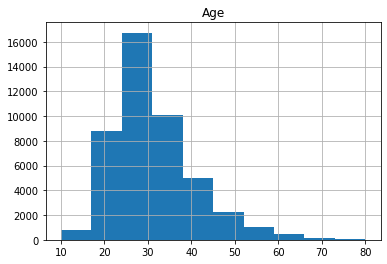

In [47]:
ages.hist("Age", bins=10)

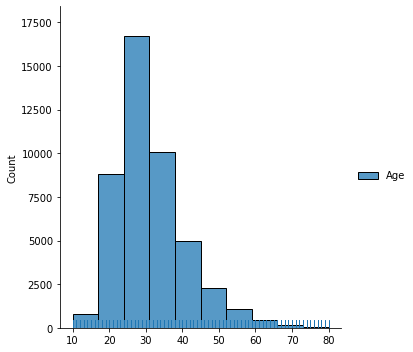

In [48]:
sns.displot(ages, bins=10, rug=True, kde=False)

## Jaki jest udział programistów hobbistów? Narysuj wykres kołowy

Będzie nas interesowała ta proporcja ze względu na płeć.

In [49]:
# przygotowanie (filtrowanie, grupowanie i zliczenie) danych na rozproszonych danych (spark sql)
# pozniej pobranie do pandasowej ramki
hobby_all = spark.sql(f"SELECT Hobbyist, COUNT(*) AS cnt FROM {table_name} WHERE Hobbyist IS NOT NULL GROUP BY Hobbyist").toPandas()
hobby_men = spark.sql(f"SELECT Hobbyist, COUNT(*) AS cnt FROM {table_name} WHERE Hobbyist IS NOT NULL AND Gender='Man' GROUP BY Hobbyist").toPandas()
hobby_women = spark.sql(f"SELECT Hobbyist, COUNT(*) AS cnt FROM {table_name} WHERE Hobbyist IS NOT NULL AND Gender='Woman' GROUP BY Hobbyist").toPandas()


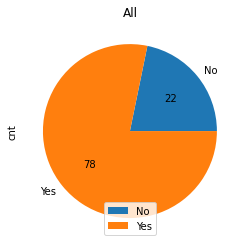

In [50]:
hobby_all.plot.pie(y='cnt', labels=hobby_all['Hobbyist'], title="All", autopct='%.0f')
plt.legend(loc="lower center")
plt.show()

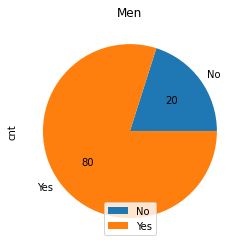

In [51]:
hobby_men.plot.pie(y='cnt', labels=hobby_men['Hobbyist'], title="Men", autopct='%.0f')
plt.legend(loc="lower center")
plt.show()

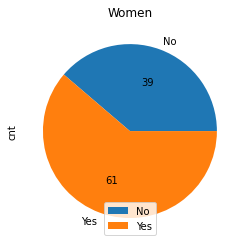

In [52]:
hobby_women.plot.pie(y='cnt', labels=hobby_women['Hobbyist'], title="Women", autopct='%.0f')
plt.legend(loc="lower center")
plt.show()

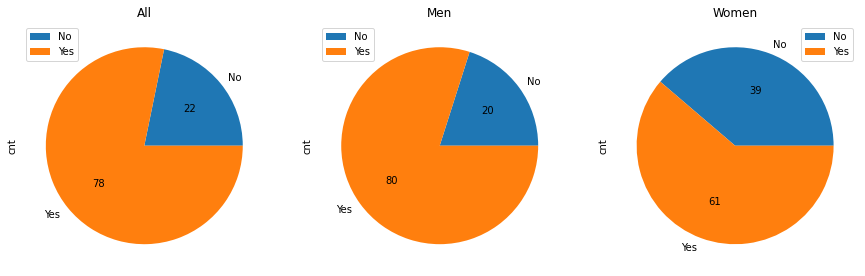

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

hobby_all.plot.pie(y='cnt', labels=hobby_all['Hobbyist'], title="All", ax=axes[0], autopct='%.0f')
hobby_men.plot.pie(y='cnt', labels=hobby_men['Hobbyist'], title="Men", ax=axes[1], autopct='%.0f')
hobby_women.plot.pie(y='cnt', labels=hobby_men['Hobbyist'], title="Women", ax=axes[2], autopct='%.0f')

plt.show()

## Wykres liniowy. Zależność między wiekiem a liczbą przepracowanych godzin
Interesują nas dla developerzy profesjonaliści (nie hobbiści) w przedziale wiekowym 18-65.

In [54]:
# przygotowanie (filtrowanie, grupowanie, wyliczenie sredniej oraz sortowanie) danych na rozproszonych danych (spark sql)
# pozniej pobranie do pandasowej ramki

age_work = spark.sql(f"SELECT age, CAST (avg(WorkWeekHrs) AS INT) AS avg FROM {table_name} \
            WHERE WorkWeekHrs IS NOT NULL AND age BETWEEN 18 AND 65 AND hobbyist = 'No' \
            GROUP BY age \
            ORDER BY age ASC").toPandas()

In [55]:
age_work

,age,avg
0,18.0,30
1,19.0,36
2,20.0,33
3,21.0,42
4,22.0,38
5,23.0,37
6,24.0,40
7,24.5,54
8,25.0,38
9,26.0,39


<AxesSubplot:xlabel='age'>

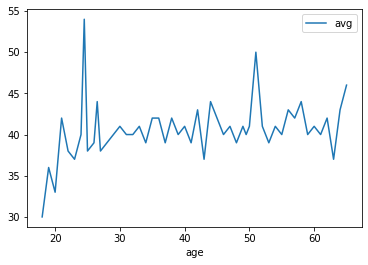

In [56]:
age_work.plot(x='age', y='avg', kind='line')

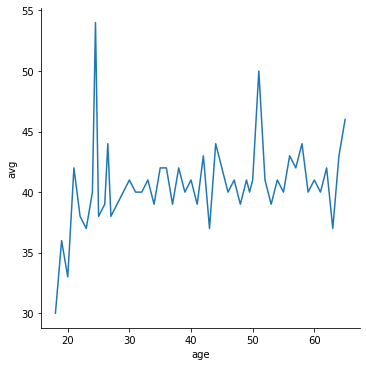

In [57]:
sns.relplot(x="age", y="avg", kind="line", data=age_work);

## Wykres słupkowy. Pokaż liczbę respondentów na kraj

Interesuje nas tylko 10 krajów o najwyższej liczbie respondentow.

In [58]:
# przygotowanie (grupowanie, zliczenie, sortowanie oraz przyciecie do 10 wyników) danych na rozproszonych danych (spark sql)
# pozniej pobranie do pandasowej ramki

max_countries = spark.sql(f"SELECT country, COUNT(*) AS cnt \
                FROM {table_name} \
                GROUP BY country \
                ORDER BY cnt DESC \
                LIMIT 10 ").toPandas()

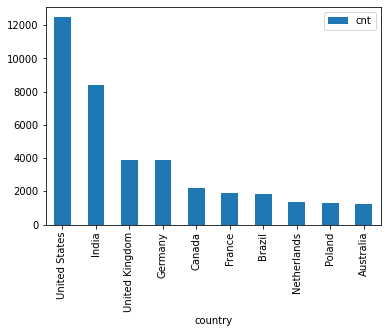

In [59]:
max_countries.plot.bar(y='cnt', x='country')
plt.show()

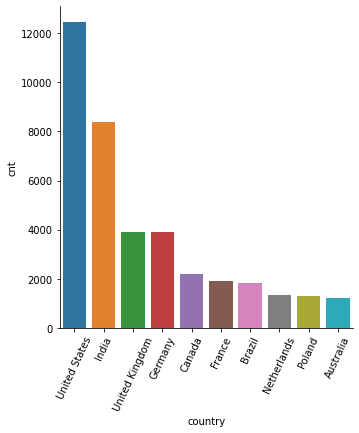

In [60]:
sns.catplot(x="country", y="cnt", kind="bar",\
            data=max_countries).set_xticklabels(rotation=65)
plt.show()

## Wykres słupkowy. Średnie zarobki w  krajach w ktorych jest powyzej 1000 respondentów

In [61]:
# przygotowanie (filtrowanie, grupowanie, wyliczenie sredniej, filtrowanie po liczności i grup oraz sortowanie) danych na rozproszonych danych (spark sql)
# pozniej pobranie do pandasowej ramki

country_salary = spark.sql(f"SELECT country, \
    CAST (avg(ConvertedComp) AS INT) as avg \
    FROM {table_name} \
    WHERE country IS NOT NULL \
    GROUP BY country \
    HAVING COUNT(*) > 1000 \
    ORDER BY avg DESC ").toPandas()

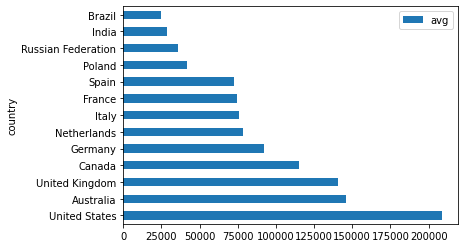

In [62]:
country_salary.plot.barh(("country"))
plt.show()

## Boxplot. Pokaz rozklad pensji w krajach gdzie jest powyzej 1000 respondentów
Tutaj będziemy musieli skorzystać z podzapytania.

In [63]:
# przygotowanie danych na rozproszonych danych (spark sql). Mamy tu do czynienia z podzapytaniem
# pozniej pobranie do pandasowej ramki

country_comp = spark.sql(f"SELECT country, CAST(ConvertedComp AS INT) \
                FROM {table_name} \
                WHERE country IN (SELECT country FROM {table_name} GROUP BY country HAVING COUNT(*) > 1000) \
                AND ConvertedComp IS NOT NULL AND ConvertedComp > 0 \
                ORDER BY ConvertedComp desc").toPandas()
country_comp

,country,ConvertedComp
0,United States,2000000
1,United States,2000000
2,United States,2000000
3,United States,2000000
4,United States,2000000
...,...,...
23671,India,12
23672,India,7
23673,India,7
23674,Canada,1


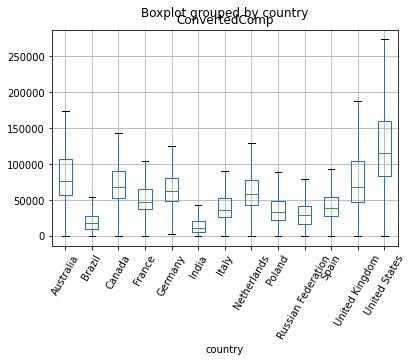

In [64]:
country_comp.boxplot(column="ConvertedComp", by="country", \
                     showfliers=False, rot=60, meanline=True)
plt.show()

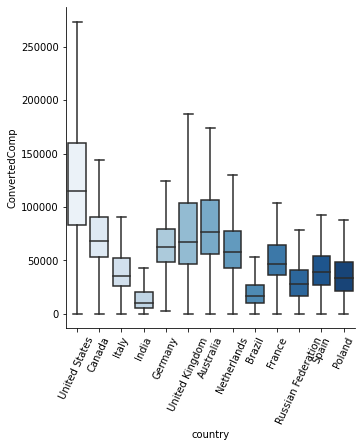

In [65]:
sns.catplot(x="country", y="ConvertedComp", kind="box", \
            showfliers=False, data=country_comp, palette="Blues")\
    .set_xticklabels(rotation=65)
plt.show()

## <span style='background:yellow'> ZADANIE 3 </span>
Narysuj rozklad pensji w zaleznosci od plci.

## Narysuj wykres popularnosci jezykow programowania

In [66]:
spark.sql(f"select LanguageWorkedWith from {table_name} where LanguageWorkedWith IS NOT NULL").show(truncate=False)

+----------------------------------------------------------------------------------------+
|LanguageWorkedWith                                                                      |
+----------------------------------------------------------------------------------------+
|C#;HTML/CSS;JavaScript                                                                  |
|JavaScript;Swift                                                                        |
|Objective-C;Python;Swift                                                                |
|HTML/CSS;Ruby;SQL                                                                       |
|HTML/CSS;Java;JavaScript                                                                |
|C#;HTML/CSS;PHP                                                                         |
|Python;SQL                                                                              |
|HTML/CSS;JavaScript;PHP                                                                 |

Języki programowania są zapisane w pojedynczej komórce. Będzie trzeba je rozdzielić i zliczyć. Tak przygotowane dane dopiero posłużą nam do narysowania wykresu. Wykorzystamy funkcję `posexplode`.

In [67]:
langs = spark.sql(f"select LanguageWorkedWith from {table_name} where LanguageWorkedWith IS NOT NULL")

In [68]:
from pyspark.sql.functions import *

langs.select(
        posexplode(split("LanguageWorkedWith", ";")).alias("pos", "language")
    ).show()

+---+-----------+
|pos|   language|
+---+-----------+
|  0|         C#|
|  1|   HTML/CSS|
|  2| JavaScript|
|  0| JavaScript|
|  1|      Swift|
|  0|Objective-C|
|  1|     Python|
|  2|      Swift|
|  0|   HTML/CSS|
|  1|       Ruby|
|  2|        SQL|
|  0|   HTML/CSS|
|  1|       Java|
|  2| JavaScript|
|  0|         C#|
|  1|   HTML/CSS|
|  2|        PHP|
|  0|     Python|
|  1|        SQL|
|  0|   HTML/CSS|
+---+-----------+
only showing top 20 rows



In [69]:
langs.select(
        posexplode(split("LanguageWorkedWith", ";")).alias("pos", "language")).groupBy("language").count().orderBy("count").show()

+--------------------+-----+
|            language|count|
+--------------------+-----+
|               Julia|  519|
|             Haskell| 1222|
|                Perl| 1796|
|               Scala| 2052|
|                Dart| 2280|
|         Objective-C| 2340|
|                Rust| 2929|
|                   R| 3288|
|               Swift| 3397|
|                 VBA| 3499|
|            Assembly| 3553|
|                Ruby| 4046|
|              Kotlin| 4468|
|                  Go| 5038|
|                   C|12487|
|                 C++|13707|
|          TypeScript|14578|
|                 PHP|15007|
|                  C#|18041|
|Bash/Shell/PowerS...|18980|
+--------------------+-----+
only showing top 20 rows



In [70]:
langs_pd = langs.select(
        posexplode(split("LanguageWorkedWith", ";")).alias("pos", "language")).groupBy("language").count().orderBy("count").toPandas()
langs_pd

,language,count
0,Julia,519
1,Haskell,1222
2,Perl,1796
3,Scala,2052
4,Dart,2280
5,Objective-C,2340
6,Rust,2929
7,R,3288
8,Swift,3397
9,VBA,3499


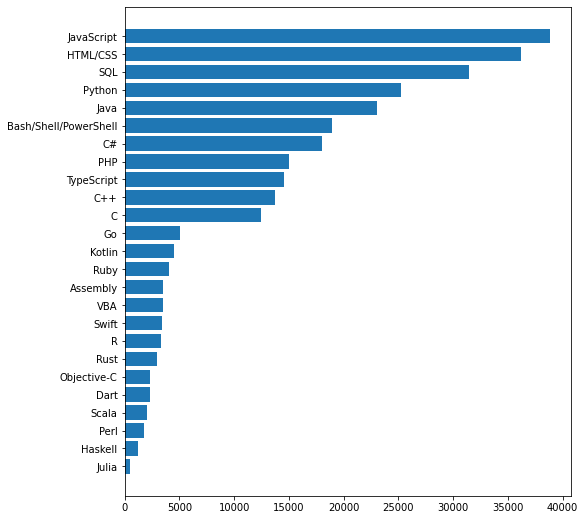

In [71]:
from matplotlib.pyplot import figure

figure(figsize=(8, 9))
plt.barh(width=langs_pd["count"], y=langs_pd["language"])
plt.show()

## Narysuj wykres popularnosci jezykow wsrod Data Scientists


Zdefiniujmy sobie funkcję, która przekształca nam języki do wymaganej przez nas postaci

In [72]:
from pyspark.sql.functions import *

def prepare_lang(df, colName='LanguageWorkedWith'):
    summary = df.select(posexplode(split(colName, ";")).alias("pos", "language")).groupBy("language").count().orderBy("count")
    return summary

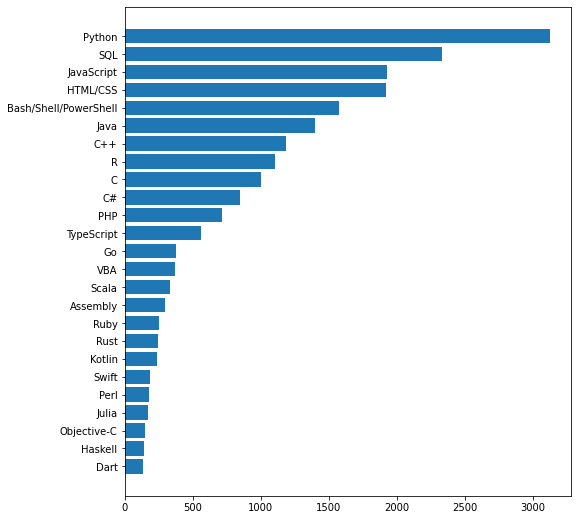

In [73]:
langs_ds = spark.sql(f"SELECT LanguageWorkedWith \
                FROM {table_name} \
                WHERE DevType LIKE '%Data scientist%'")

sum_lang = prepare_lang(langs_ds).toPandas()

figure(figsize=(8, 9))
plt.barh(width=sum_lang["count"], y=sum_lang["language"])
plt.show()

## Narysuj wykres którego chcą wykorzystywać w przyszłości Data Scientists

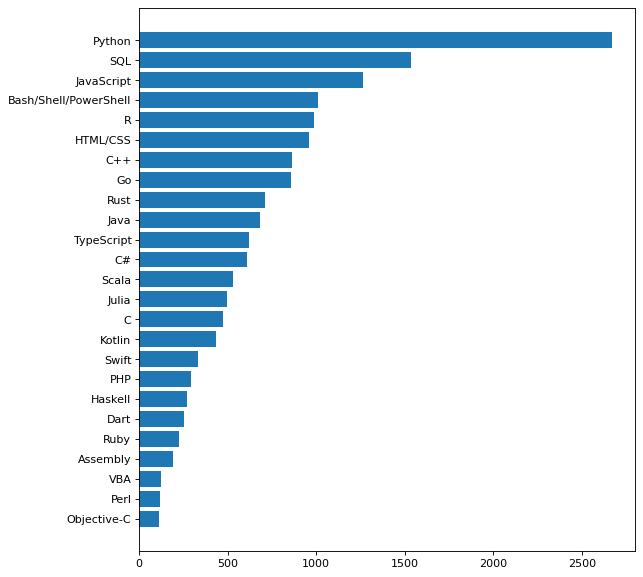

In [74]:
lang_desired = spark.sql(f"select LanguageDesireNextYear \
                from {table_name} \
                where DevType like '%Data scientist%'")

sum_lang = prepare_lang(lang_desired, 'LanguageDesireNextYear').toPandas()

figure(num=None, figsize=(8, 9), dpi=80, facecolor='w', edgecolor='k')
plt.barh(width=sum_lang["count"], y=sum_lang["language"])
plt.show()

## Narysuj wykres prezentujący liczbę godzin na pracy w zależności od wykształcenia

In [75]:
spark.sql(f"select distinct EdLevel from {table_name}").show(truncate=False) # jakie są wartości wykształcenia

+----------------------------------------------------------------------------------+
|EdLevel                                                                           |
+----------------------------------------------------------------------------------+
|Primary/elementary school                                                         |
|null                                                                              |
|Other doctoral degree (Ph.D., Ed.D., etc.)                                        |
|I never completed any formal education                                            |
|Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                      |
|Associate degree (A.A., A.S., etc.)                                               |
|Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)|
|Professional degree (JD, MD, etc.)                                                |
|Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                 

In [76]:

ed_pandas = spark.sql(f"SELECT EdLevel, WorkWeekHrs FROM {table_name} \
            WHERE WorkWeekHrs BETWEEN 10 AND 80 \
            AND (EdLevel LIKE '%Bachelor%' OR EdLevel LIKE '%Master%' OR EdLevel LIKE '%Other doctoral%')").toPandas()

ed_pandas['EdLevel'] = ed_pandas['EdLevel'].replace('Bachelor’s degree (B.A., B.S., B.Eng., etc.)','Bachelor')
ed_pandas['EdLevel'] = ed_pandas['EdLevel'].replace('Master’s degree (M.A., M.S., M.Eng., MBA, etc.)','Master')
ed_pandas['EdLevel'] = ed_pandas['EdLevel'].replace('Other doctoral degree (Ph.D., Ed.D., etc.)','Doctor')

ed_pandas

,EdLevel,WorkWeekHrs
0,Master,50.0
1,Master,40.0
2,Bachelor,39.0
3,Master,36.0
4,Bachelor,40.0
...,...,...
30412,Master,40.0
30413,Master,35.0
30414,Bachelor,40.0
30415,Bachelor,45.0


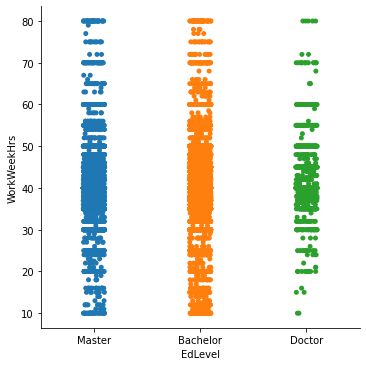

In [77]:
sns.catplot(x="EdLevel", y="WorkWeekHrs", data=ed_pandas)


## Narysuj wykres wiolinowy pokazujacy rozkład dochodów w zależności od wykształcenia

In [78]:
ed_pay = spark.sql(f"SELECT EdLevel, CAST (CompTotal AS INT) AS CompTotal FROM {table_name} \
            WHERE CompTotal BETWEEN 0 AND 1000000  \
            AND (EdLevel LIKE '%Bachelor%' OR EdLevel LIKE '%Master%' OR EdLevel LIKE '%Other doctoral%')").toPandas()

ed_pay['EdLevel'] = ed_pay['EdLevel'].replace('Bachelor’s degree (B.A., B.S., B.Eng., etc.)','Bachelor')
ed_pay['EdLevel'] = ed_pay['EdLevel'].replace('Master’s degree (M.A., M.S., M.Eng., MBA, etc.)','Master')
ed_pay['EdLevel'] = ed_pay['EdLevel'].replace('Other doctoral degree (Ph.D., Ed.D., etc.)','Doctor')

ed_pay

,EdLevel,CompTotal
0,Bachelor,116000
1,Master,25000
2,Bachelor,31000
3,Bachelor,7000
4,Bachelor,79000
...,...,...
25067,Doctor,140000
25068,Master,3000
25069,Bachelor,22000
25070,Master,120000


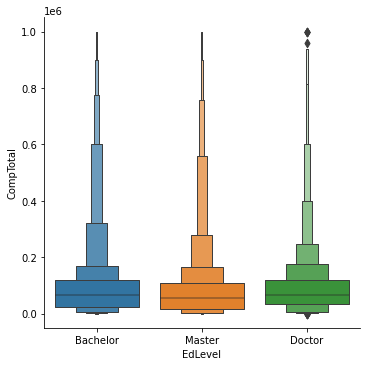

In [79]:
sns.catplot(x="EdLevel", y="CompTotal", kind="boxen",
            data=ed_pay);

## ⭐ Narysuj heatmape odwiedzin na StackOverflow dla wybranych krajów ⭐

In [80]:
spark.sql(f"SELECT DISTINCT SOVisitFreq FROM {table_name}").show(truncate=False)

+--------------------------------------------------+
|SOVisitFreq                                       |
+--------------------------------------------------+
|A few times per week                              |
|A few times per month or weekly                   |
|null                                              |
|Daily or almost daily                             |
|I have never visited Stack Overflow (before today)|
|Less than once per month or monthly               |
|Multiple times per day                            |
+--------------------------------------------------+



In [81]:
so_v = spark.sql(f"SELECT SOVisitFreq, t1.country, COUNT(*)/first(t2.t) AS cnt from {table_name} t1 \
            JOIN (SELECT country, COUNT(*) as t FROM {table_name} GROUP BY country) t2 \
            ON t1.country = t2.country \
            WHERE t1.country IS NOT NULL AND SOVisitFreq IS NOT NULL \
            AND t1.country IN ('Poland', 'United States', 'Russian Federation', 'China', 'India', 'Germany', 'Japan') \
            GROUP BY t1.country, SOVisitFreq").toPandas()

so_v['SOVisitFreq'] = pd.Categorical(so_v['SOVisitFreq'], ["I have never visited Stack Overflow (before today)", "Less than once per month or monthly", "A few times per month or weekly", "A few times per week", "Daily or almost daily", "Multiple times per day"])
# so_v.sort_values['SOVisitFreq']


<AxesSubplot:xlabel='SOVisitFreq', ylabel='country'>

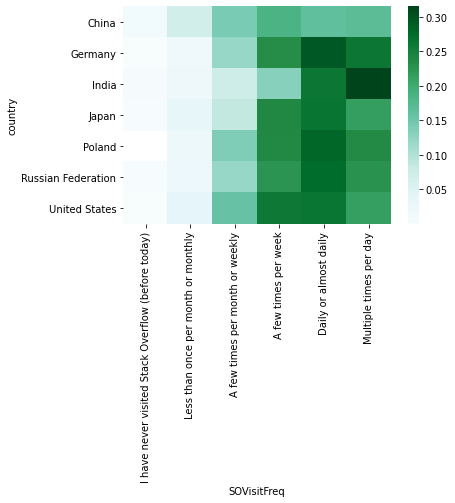

In [82]:
heatmap2_data = pd.pivot_table(so_v, values='cnt', index=['country'], columns='SOVisitFreq')
sns.heatmap(heatmap2_data, cmap="BuGn")

## <span style='background:yellow'> ZADANIE 4 </span>
* Narysuj wykres słupkowy popularności wykorzystywanych baz danych przez profesjonalnych programistów.
* Narysuj wykres kołowy przedstawiający procentowy udział poziomu wykształcenia inz, mgr i dr w grupie respondentów.

In [83]:
spark.stop()